In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import os
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch import nn

sys.path.append("/home/brysongray/tractography")
import load_data
from image import Image
import make_simulated_neurons as msn

DEVICE = "cuda"
dtype = torch.float32

date = datetime.now().strftime("%m-%d-%y")


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv3d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm3d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv3d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm3d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 3):
        super(ResNet, self).__init__()
        self.infilters = 64
        # self.conv1 = nn.Sequential(
        #                 nn.Conv3d(3, 64, kernel_size=3, stride=2, padding=1),
        #                 nn.BatchNorm3d(64),
        #                 nn.ReLU())
        self.conv1 = nn.Sequential(
                        nn.Conv3d(3, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm3d(64),
                        nn.ReLU())
        # self.maxpool = nn.MaxPool3d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 1)
        # self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool3d(4, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, filters, blocks, stride=1):
        downsample = None
        if stride != 1 or self.infilters != filters:

            downsample = nn.Sequential(
                nn.Conv3d(self.infilters, filters, kernel_size=1, stride=stride),
                nn.BatchNorm3d(filters),
            )
        layers = []
        layers.append(block(self.infilters, filters, stride, downsample))
        self.infilters = filters
        for i in range(1, blocks):
            layers.append(block(self.infilters, filters))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        # x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)

        return x
    

def collect_data(labels_dir, image_dir, out_dir, name, date, samples_per_file=500, rng=None):

    if rng is None:
        rng = np.random.default_rng()

    datasets = [dir for dir in os.listdir(labels_dir) if dir[0] != "."]
    files = []
    for dataset in datasets:
        labels_path = os.path.join(labels_dir, dataset)
        if "CNG version" in os.listdir(labels_path):
            labels_path = labels_path + "/CNG version"
        elif "Source-Version" in os.listdir(labels_path):
            labels_path = labels_path + "/Source-Version"
        else:
            continue

        for f in os.listdir(labels_path):
            if f.endswith("swc") and f[0] != ".":
                files.append(os.path.join(labels_path, f))

    sample_points = {}
    for labels_file in files:
        swc_list = load_data.read_swc(labels_file)
        sections, section_graph, branches, terminals, scale = load_data.parse_swc_list(swc_list, adjust=True)
        rand_sections = rng.choice(list(sections.keys()), size=samples_per_file)
        points = []
        for i in rand_sections:
            section_flat = sections[i].flatten(0,1) # type: ignore # 
            random_point = rng.choice(np.arange(len(section_flat)))
            random_point = section_flat[random_point]
            # random translation vector from normal distribution about random_point
            translation = rng.uniform(low=0.0, high=1.0, size=(3,))*8.0 - 4.0
            random_point += translation
            points.append(random_point)
        points = np.array(points)
        fname = labels_file.split("/")[-1].split(".CNG")[0]
        sample_points[fname] = points

    os.makedirs(os.path.join(out_dir,"observations"), exist_ok=True)
    image_files = os.listdir(image_dir)
    annotations = {}
    obs_id = 0
    for f in image_files:
        fname = f.split(".CNG")[0]
        points = sample_points[fname]
        data = torch.load(os.path.join(image_dir, f), weights_only=True)
        img = data["image"]
        img = Image(img)
        branch_mask = data["branch_mask"]
        for point in points:
            patch, _ = img.crop(torch.tensor(point), 7, pad=True, value=0.0)
            i,j,k = [int(np.round(x)) for x in point]
            label = branch_mask[0, i, j, k].item()
            fname = f"obs_{obs_id}.pt"
            torch.save(patch, os.path.join(os.path.join(out_dir, "observations"), fname))
            annotations[fname] = label
            obs_id += 1

    # save annotations
    df = pd.DataFrame.from_dict(annotations, orient="index")
    df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{date}_annotations.csv"), index=False)
    # split into test and training data
    data_permutation = torch.randperm(len(annotations))
    test_idxs = data_permutation[:len(data_permutation)//5].tolist()
    training_idxs = data_permutation[len(data_permutation)//5:].tolist()
    training_annotations = {list(annotations)[i]: list(annotations.values())[i] for i in training_idxs}
    test_annotations = {list(annotations)[i]: list(annotations.values())[i] for i in test_idxs}
    # save 
    df = pd.DataFrame.from_dict(training_annotations, orient="index")
    df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{date}_training_annotations.csv"))
    df = pd.DataFrame.from_dict(test_annotations, orient="index")
    df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{date}_test_annotations.csv"))


def swc_random_points(samples_per_neuron, swc_lists, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    sample_points = {}
    for i, swc_list in enumerate(swc_lists):
        sections, section_graph, branches, terminals, scale = load_data.parse_swc_list(swc_list, adjust=False)
        rand_sections = rng.choice(list(sections.keys()), size=samples_per_neuron)
        points = []
        for j in rand_sections:
            section_flat = sections[j].flatten(0,1) # type: ignore # 
            random_point = rng.choice(np.arange(len(section_flat)))
            random_point = section_flat[random_point]
            # random translation vector from normal distribution about random_point
            translation = rng.uniform(low=0.0, high=1.0, size=(3,))*8.0 - 4.0
            random_point += translation
            points.append(random_point)
        points = np.array(points)
        
        sample_points[i] = points
    
    return sample_points

In [4]:
count = 1000
rng = np.random.default_rng(7)
out_dir = "/home/brysongray/tractography/data/training_data/branch_classifier_sim_dataset_no_artifacts_"+date
name="sim_dataset_no_artifacts"
random_contrast=False

swc_lists = []
for i in tqdm(range(count)):
    swc_list = msn.make_swc_list((101,101,101),
                                length=20,
                                step_size=3.0,
                                kappa=20.0,
                                uniform_len=False,
                                random_start=True,
                                rng=rng,
                                num_branches=1) # make simulated neuron paths.
    swc_lists.append(swc_list)
    
sample_points = swc_random_points(50, swc_lists)

annotations = {}
obs_id = 0
for i in tqdm(range(count)):
    # make image from swc list
    color = np.array([1.0, 1.0, 1.0])
    background = np.array([0., 0., 0.])
    if random_contrast:
        color = rng.uniform(size=3)
        color /= np.linalg.norm(color)
        background = rng.uniform(size=3)
        background = background / np.linalg.norm(background) * 0.01
    swc_data = load_data.draw_neuron_from_swc(swc_lists[i],
                                                width=3,
                                                noise=0.0,
                                                adjust=False,
                                                neuron_color=color,
                                                background_color=background,
                                                random_brightness=False,
                                                dropout=False,
                                                binary=False,
                                                rng=rng) # Use simulated paths to draw the image.
    img = swc_data["image"]
    img = Image(img)
    branch_mask = swc_data["branch_mask"]
    points = sample_points[i]

    obs_dir = os.path.join(out_dir, "observations")
    if not os.path.exists(obs_dir):
            os.makedirs(obs_dir, exist_ok=True)

    for point in points:
            patch, _ = img.crop(torch.tensor(point), 7, pad=True, value=0.0)
            i,j,k = [int(np.round(x)) for x in point]
            label = branch_mask[0, i, j, k].item()
            fname = f"obs_{obs_id}.pt"
            torch.save(patch, os.path.join(obs_dir, fname))
            annotations[fname] = label
            obs_id += 1

# save annotations
df = pd.DataFrame.from_dict(annotations, orient="index")
df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{date}_annotations.csv"), index=False)
# split into test and training data
data_permutation = torch.randperm(len(annotations))
test_idxs = data_permutation[:len(data_permutation)//5].tolist()
training_idxs = data_permutation[len(data_permutation)//5:].tolist()
training_annotations = {list(annotations)[i]: list(annotations.values())[i] for i in training_idxs}
test_annotations = {list(annotations)[i]: list(annotations.values())[i] for i in test_idxs}
# save 
df = pd.DataFrame.from_dict(training_annotations, orient="index")
df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{date}_training_annotations.csv"))
df = pd.DataFrame.from_dict(test_annotations, orient="index")
df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{date}_test_annotations.csv"))

  0%|          | 0/1000 [00:00<?, ?it/s]

 71%|███████   | 707/1000 [00:03<00:01, 231.98it/s]


KeyboardInterrupt: 

In [42]:
collect_data(labels_dir="/home/brysongray/data/neuromorpho/",
             image_dir="/home/brysongray/tractography/data/training_data/neuromorpho_with_artifacts",
             out_dir="/home/brysongray/tractography/data/training_data/branch_classifier_neurom_dataset_artifacts_"+date,
             name="neurom_dataset_artifacts",
             date=date)

loading file: /home/brysongray/data/neuromorpho/mehder/CNG version/Rasha-CA1-Exp-April-2016-right-slide-55-secion-1.CNG.swc
loading file: /home/brysongray/data/neuromorpho/hart/CNG version/2016-10-27_541_mir-1_day_3_5.CNG.swc
loading file: /home/brysongray/data/neuromorpho/hart/CNG version/2016-10-27_541_mir-1_day_3_3.CNG.swc
loading file: /home/brysongray/data/neuromorpho/briggs/CNG version/Bub_9-13_c1.CNG.swc
loading file: /home/brysongray/data/neuromorpho/quinlan/CNG version/KQa4-12-2015-tracing.CNG.swc
loading file: /home/brysongray/data/neuromorpho/beining/CNG version/35dpi_ipsi_infra_06.CNG.swc
loading file: /home/brysongray/data/neuromorpho/kuddannaya/CNG version/Tracetest_N360_semicircle_Map2Tau_79_semi-auto_18.CNG.swc
loading file: /home/brysongray/data/neuromorpho/chiang/CNG version/Cha-F-000302.CNG.swc
loading file: /home/brysongray/data/neuromorpho/chiang/CNG version/Cha-F-600090.CNG.swc
loading file: /home/brysongray/data/neuromorpho/tolias/CNG version/L5MC-J130731a.CNG.sw

RuntimeError: The expanded size of the tensor (0) must match the existing size (823) at non-singleton dimension 3.  Target sizes: [3, 15, 15, 0].  Tensor sizes: [3, 15, 15, 823]

In [43]:
rng = np.random.default_rng(7)

labels_dir = "/home/brysongray/data/neuromorpho/"

datasets = [dir for dir in os.listdir(labels_dir) if dir[0] != "."]
files = []
for dataset in datasets:
    labels_path = os.path.join(labels_dir, dataset)
    if "CNG version" in os.listdir(labels_path):
        labels_path = labels_path + "/CNG version"
    elif "Source-Version" in os.listdir(labels_path):
        labels_path = labels_path + "/Source-Version"
    else:
        continue

    for f in os.listdir(labels_path):
        if f.endswith("swc") and f[0] != ".":
            files.append(os.path.join(labels_path, f))

samples_per_file = 1000
sample_points = {}
for labels_file in files:
    fname = labels_file.split("/")[-1].split(".CNG")[0]
    swc_list = load_data.read_swc(labels_file)
    sections, section_graph, branches, terminals, scale = load_data.parse_swc_list(swc_list, adjust=True)
    rand_sections = rng.choice(list(sections.keys()), size=samples_per_file)
    points = []
    for i in rand_sections:
        section_flat = sections[i].flatten(0,1).detach().clone() # type: ignore # 
        random_point = rng.choice(np.arange(len(section_flat)))
        random_point = section_flat[random_point]
        # random translation vector from normal distribution about random_point
        translation = rng.uniform(low=0.0, high=1.0, size=(3,))*8.0 - 4.0
        random_point += translation
        points.append(random_point)
    points = torch.stack(points)
    sample_points[fname] = points

torch.save(sample_points, "/home/brysongray/tractography/data/sample_points.pt")

loading file: /home/brysongray/data/neuromorpho/mehder/CNG version/Rasha-CA1-Exp-April-2016-right-slide-55-secion-1.CNG.swc
loading file: /home/brysongray/data/neuromorpho/hart/CNG version/2016-10-27_541_mir-1_day_3_5.CNG.swc


/tmp/ipykernel_6228/3193434125.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  random_point += translation


loading file: /home/brysongray/data/neuromorpho/hart/CNG version/2016-10-27_541_mir-1_day_3_3.CNG.swc
loading file: /home/brysongray/data/neuromorpho/briggs/CNG version/Bub_9-13_c1.CNG.swc
loading file: /home/brysongray/data/neuromorpho/quinlan/CNG version/KQa4-12-2015-tracing.CNG.swc
loading file: /home/brysongray/data/neuromorpho/beining/CNG version/35dpi_ipsi_infra_06.CNG.swc
loading file: /home/brysongray/data/neuromorpho/kuddannaya/CNG version/Tracetest_N360_semicircle_Map2Tau_79_semi-auto_18.CNG.swc
loading file: /home/brysongray/data/neuromorpho/chiang/CNG version/Cha-F-000302.CNG.swc
loading file: /home/brysongray/data/neuromorpho/chiang/CNG version/Cha-F-600090.CNG.swc
loading file: /home/brysongray/data/neuromorpho/tolias/CNG version/L5MC-J130731a.CNG.swc
loading file: /home/brysongray/data/neuromorpho/dierssen/CNG version/WT_6mo_3_11.CNG.swc
loading file: /home/brysongray/data/neuromorpho/borst/CNG version/dHSN_02l.CNG.swc
loading file: /home/brysongray/data/neuromorpho/stee

In [27]:
image_dir = "/home/brysongray/tractography/neuron_trx/training_data/neuromorpho"
image_files = os.listdir(image_dir)
f = image_files[0]
data = torch.load(os.path.join(image_dir, f), weights_only=True)

In [28]:
# torch.save(sample_points, "sample_points.pt")
sample_points = torch.load("sample_points.pt", weights_only=True)

In [64]:
sample_points = torch.load("sample_points.pt", weights_only=True)

name = "neurom_dataset_with_artifacts"
image_dir = "/home/brysongray/tractography/data/training_data/neuromorpho_with_artifacts"
out_dir = f"/home/brysongray/tractography/data/training_data/branch_classifier_neurom_dataset_artifacts_{date}"
os.makedirs(os.path.join(out_dir,"observations"), exist_ok=True)
image_files = os.listdir(image_dir)
annotations = {}
obs_id = 0
for f in image_files:
    fname = f.split(".CNG")[0]
    print(fname)
    points = torch.tensor(sample_points[fname])
    data = torch.load(os.path.join(image_dir, f), weights_only=True)
    img = data["image"]
    img = Image(img)
    branch_mask = data["branch_mask"]
    for point in points:
        # point = torch.round(point).to(dtype=torch.int)
        patch, _ = img.crop(point, 7, pad=True, value=0.0)
        i,j,k = [int(torch.floor(x)) for x in point]
        label = branch_mask[0, i, j, k].item()
        fname = f"obs_{obs_id}.pt"
        torch.save(patch, os.path.join(os.path.join(out_dir, "observations"), fname))
        annotations[fname] = label
        obs_id += 1

# save annotations
df = pd.DataFrame.from_dict(annotations, orient="index")
df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{date}_annotations.csv"), index=False)
# split into test and training data
data_permutation = torch.randperm(len(annotations))
test_idxs = data_permutation[:len(data_permutation)//5].tolist()
training_idxs = data_permutation[len(data_permutation)//5:].tolist()
training_annotations = {list(annotations)[i]: list(annotations.values())[i] for i in training_idxs}
test_annotations = {list(annotations)[i]: list(annotations.values())[i] for i in test_idxs}
# save 
df = pd.DataFrame.from_dict(training_annotations, orient="index")
df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{date}_training_annotations.csv"))
df = pd.DataFrame.from_dict(test_annotations, orient="index")
df.to_csv(os.path.join(out_dir, f"branch_classifier_{name}_{date}_test_annotations.csv"))

SN_Adulthood_Control_M_Animal08_Trace005


/tmp/ipykernel_6228/1802225951.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(sample_points[fname])


skel_20220_sorted
SN_5xFAD_6mpos_M_Animal03_Trace033
1-CTR_2w_Female_Nac_6
Tracetest_N360_semicircle_Map2Tau_79_semi-auto_18
FC_Development_P15_M_Animal02_Trace109
CeA_Astrocyte_3_021
646805498_transformed
SD3
14dpi_WT2_S6_2
C242-01-08-14-B1
20160916_BGUG_HuC_ltRFP_d7_F13
2016-10-27_541_mir-1_day_3_5
cort4c4pg1d
Cha-F-000302
CN_Development_P22_F_Animal03_Trace009
pcs74_8
P3_CV3_79
S1_CKp25_1w_M_Animal02_Trace067
SN_Ovariectomy_Animal02_Trace052
MC-Aged-Cont-S2
L5MC-J130731a
Bub_9-13_c1
S1_5xFAD_3mpos_M_Animal03_Trace037
FC_Development_P22_F_Animal03_Trace164
Cell_134_MPD_12_FT_10_XYZ_Sorted-swc_N3DFix-swc_4
KC-p-5303804
L100P-GSK3-Het-9
8-STRESS_2w_Female_HIP_7
farsight879
13_L3_C3_N5
Cell_528_MPD_8_FT_10_XYZ_Sorted-swc_N3DFix-swc_1
7month-Arctic-C5aR1-KO-11_2
S1_CKp25_6w_M_Animal04_Trace008
2016-10-27_541_mir-1_day_3_3
orphan_3807
WT_6mo_3_11
194-2-6lw
DG_5xFAD_3mpos_F_Animal02_Trace178
D2_C_22
FC_Adulthood_Control_M_Animal01_Trace036
Aged_mice_VAC-PBS10_58-DG-1
S1_CKp25_6w_F_Animal02

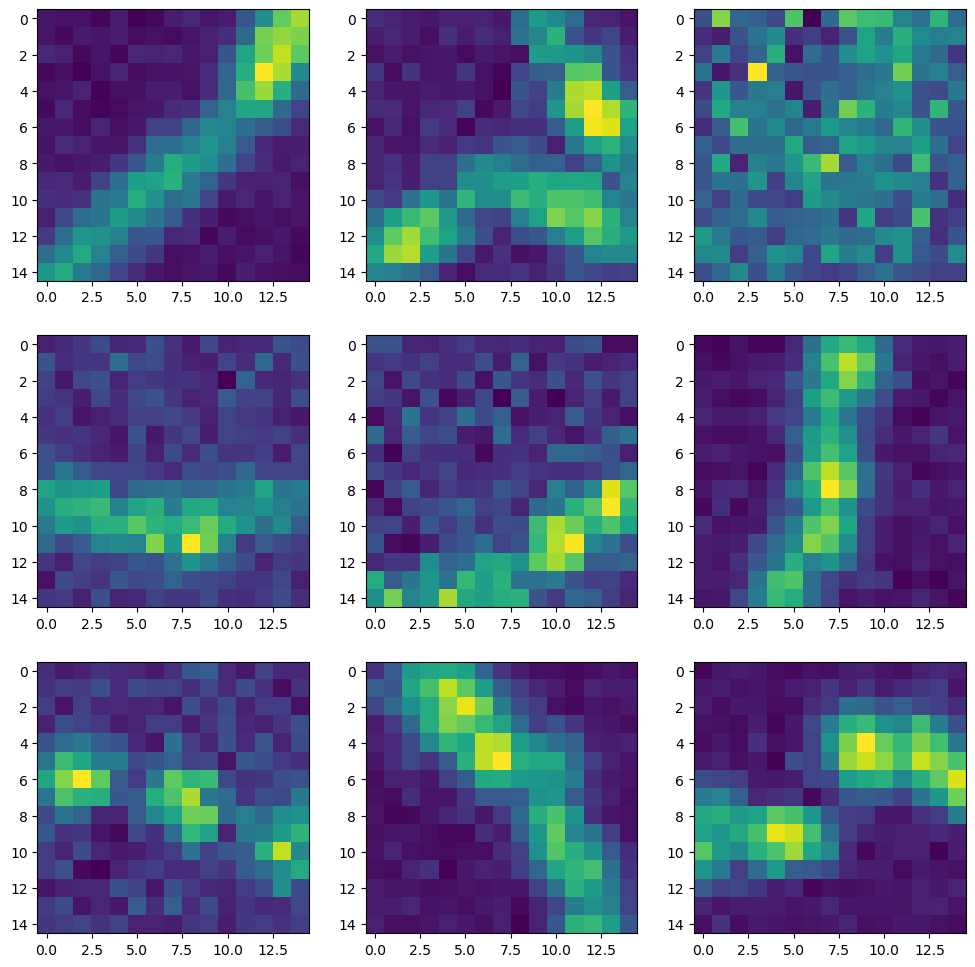

In [58]:
# dir = "/home/brysongray/tractography/neuron_trx/training_data/branch_classifier_neurom_dataset_1_1-7-25_15/observations"
# dir = "/home/brysongray/tractography/data/training_data/branch_classifier_sim_dataset_artifacts_01-24-25/observations"
dir = "/home/brysongray/tractography/data/training_data/branch_classifier_neurom_dataset_artifacts_01-24-25/observations"

files = os.listdir(dir)

fig, ax = plt.subplots(3,3, figsize=(12,12))
for i,f in enumerate(files[:9]):
    img = torch.load(os.path.join(dir, f), weights_only=True)
    ax = ax.ravel()
    ax[i].imshow(img[0].amax(0))


In [4]:
# define dataset class
class StateData(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) # type: ignore
        image = torch.load(img_path, weights_only=True)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# define transforms
def transform(image):
    perm = torch.randperm(3) + 1
    image = image.permute([0,*perm])
    if torch.rand(1)>0.5: image = image.flip(-1)
    if torch.rand(1)>0.5: image = image.flip(-2)
    if torch.rand(1)>0.5: image = image.flip(-3)
    
    return image


def train_loop(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    positive_count = len(np.where(dataloader.dataset.img_labels.iloc[:,1] > 0.0)[0])
    negative_count = size - positive_count
    losses = []
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        out = model(X[:,:3].to(device=DEVICE))
        out = torch.nn.functional.sigmoid(out.squeeze())
        # out = torch.nn.functional.softmax(out, dim=1)
        # y = torch.nn.functional.one_hot(y, num_classes=3)
        y = y.to(dtype=torch.float, device=DEVICE)
        weights = torch.where(y > 0.0, positive_count/size, negative_count/size)
        loss = loss_fn(out,y)
        loss = torch.mean(loss * weights)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X) + len(X)
            losses.append(loss)
            accuracy = ((out > 0.5) == y).type(torch.float).sum().item()
            accuracy = accuracy / len(y) * 100
            print(f"Accuracy: {accuracy}, Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return losses

def test_loop(dataloader, model, loss_fn):

    size = len(dataloader.dataset)
    positive_count = len(np.where(dataloader.dataset.img_labels.iloc[:,1] > 0.0)[0])
    negative_count = size - positive_count
    model.eval()
    num_batches = len(dataloader)
    test_loss, TP, TN, FP, FN = 0,0,0,0,0
    with torch.no_grad():
        for X,y in dataloader:
            out = model(X[:,:3].to(device=DEVICE))
            out = torch.nn.functional.sigmoid(out.squeeze())
            # out = torch.nn.functional.softmax(out, dim=1)
            # y = torch.nn.functional.one_hot(y, num_classes=3)
            y = y.to(dtype=torch.float, device=DEVICE)
            weights = torch.where(y > 0.0, positive_count/size, negative_count/size)
            loss = loss_fn(out,y)
            loss = torch.mean(loss * weights)
            test_loss += loss.item()
            # correct += (torch.argmax(out, dim=1) == torch.argmax(y, dim=1)).type(torch.float).sum().item()
            # correct += ((out > 0.5) == y).type(torch.float).sum().item()
            threshold = 0.5
            TP_ = ((out > threshold) & (y > 0.0)).type(torch.float).sum().item()
            TN_ = ((out <= threshold) & (y <= 0.0)).type(torch.float).sum().item()
            FP_ = ((out > threshold).sum().item() - TP_)
            FN_ = ((out <= threshold).sum().item() - TN_)
            TP += TP_
            TN += TN_
            FP += FP_
            FN += FN_

    test_loss /= num_batches
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    correct = (TP + TN) / size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n\
           Precision: {precision:>0.3f}, Recall: {recall:>0.3f}")
    # print(f"Avg MSE loss: {test_loss:>8f} \n")

In [10]:
training_data = StateData(annotations_file="/home/brysongray/tractography/data/training_data/branch_classifier_neurom_dataset_no_artifacts_01-24-25/branch_classifier_neurom_dataset_no_artifacts_01-24-25_training_annotations.csv",
                          img_dir="/home/brysongray/tractography/data/training_data/branch_classifier_neurom_dataset_no_artifacts_01-24-25/observations",
                          transform=transform)
test_data = StateData(annotations_file="/home/brysongray/tractography/data/training_data/branch_classifier_neurom_dataset_no_artifacts_01-24-25/branch_classifier_neurom_dataset_no_artifacts_01-24-25_test_annotations.csv",
                          img_dir="/home/brysongray/tractography/data/training_data/branch_classifier_neurom_dataset_no_artifacts_01-24-25/observations")

In [13]:
nonzero_sample_count = np.sum(training_data.img_labels.iloc[:,1] > 0.0)
nonzero_weight = 1. / nonzero_sample_count
zero_sample_count = len(training_data.img_labels) - nonzero_sample_count
zero_weight = 1. / zero_sample_count
training_samples_weight = [nonzero_weight if t > 0.0 else zero_weight for t in training_data.img_labels.iloc[:,1]]
training_sampler = WeightedRandomSampler(training_samples_weight, len(training_samples_weight))

nonzero_sample_count = np.sum(test_data.img_labels.iloc[:,1] > 0.0)
nonzero_weight = 1. / nonzero_sample_count
zero_weight = 1. / (len(test_data.img_labels) - nonzero_sample_count)
test_samples_weight = [nonzero_weight if t > 0.0 else zero_weight for t in test_data.img_labels.iloc[:,1]]
test_sampler = WeightedRandomSampler(test_samples_weight, len(test_samples_weight))

# initialize dataloaders
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

train_dataloader = DataLoader(training_data, batch_size=64, sampler=training_sampler)
test_dataloader = DataLoader(test_data, batch_size=64, sampler=test_sampler)

In [12]:
out_dir = "/home/brysongray/tractography/pretrained_models/neurom_no_artifacts_classifier/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)
    
lr = 1e-3
epochs = 25
in_channels = 4

# classifier = Net(chin=in_channels, chout=3)
classifier = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=1)
classifier = classifier.to(device=DEVICE, dtype=dtype)

#load a previously trained model
# classifier_state_dict = torch.load("/home/brysongray/tractography/pretrained_models/neurom_with_artifacts_classifier/resnet_classifier_01-24-25_checkpoint-6.pt", weights_only=True)
# classifier.load_state_dict(classifier_state_dict)

classifier.train()
classifier_optimizer = optim.AdamW(classifier.parameters(), lr=lr)
binary_loss = torch.nn.BCELoss()
cross_entropy_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()

for i,t in enumerate(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    loop_losses = train_loop(train_dataloader, classifier, binary_loss, classifier_optimizer)
    test_loop(test_dataloader, classifier, binary_loss)
    torch.save(classifier.state_dict(), os.path.join(out_dir, f"resnet_classifier_{date}_checkpoint-{i}.pt"))
print("Done!")


Epoch 1
-------------------------------
Accuracy: 57.8125, Loss: 0.271621  [   64/57600]
Accuracy: 71.875, Loss: 1.991424  [  704/57600]
Accuracy: 82.8125, Loss: 0.169316  [ 1344/57600]
Accuracy: 78.125, Loss: 0.318538  [ 1984/57600]
Accuracy: 75.0, Loss: 0.270964  [ 2624/57600]
Accuracy: 75.0, Loss: 0.292223  [ 3264/57600]
Accuracy: 84.375, Loss: 0.256320  [ 3904/57600]
Accuracy: 81.25, Loss: 0.187409  [ 4544/57600]
Accuracy: 82.8125, Loss: 0.182644  [ 5184/57600]
Accuracy: 81.25, Loss: 0.201644  [ 5824/57600]
Accuracy: 81.25, Loss: 0.179003  [ 6464/57600]
Accuracy: 84.375, Loss: 0.224823  [ 7104/57600]
Accuracy: 89.0625, Loss: 0.126321  [ 7744/57600]
Accuracy: 81.25, Loss: 0.191251  [ 8384/57600]
Accuracy: 76.5625, Loss: 0.260141  [ 9024/57600]
Accuracy: 81.25, Loss: 0.188079  [ 9664/57600]
Accuracy: 85.9375, Loss: 0.163575  [10304/57600]
Accuracy: 85.9375, Loss: 0.172764  [10944/57600]
Accuracy: 81.25, Loss: 0.179298  [11584/57600]
Accuracy: 78.125, Loss: 0.227476  [12224/57600]
Acc

KeyboardInterrupt: 

In [9]:
classifier = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=1)
classifier = classifier.to(device=DEVICE, dtype=dtype)
classifier_state_dict = torch.load("/home/brysongray/tractography/pretrained_models/resnet_classifier_01-07-25_checkpoint-42.pt", weights_only=True)
classifier.load_state_dict(classifier_state_dict)

classifier.eval()

test_dataloader = DataLoader(test_data, batch_size=64, sampler=test_sampler)
binary_loss = torch.nn.BCELoss()

test_loop(test_dataloader, classifier, binary_loss)


Test Error: 
 Accuracy: 93.3%, Avg loss: 0.092713 
           Precision: 0.905, Recall: 0.967


In [9]:
classifier = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=1)
classifier = classifier.to(device=DEVICE, dtype=dtype)
classifier_state_dict = torch.load("/home/brysongray/tractography/pretrained_models/neurom_with_artifacts_classifier/resnet_classifier_01-24-25_checkpoint-16.pt", weights_only=True)
classifier.load_state_dict(classifier_state_dict)

classifier.eval()

test_dataloader = DataLoader(test_data, batch_size=64, sampler=test_sampler)
binary_loss = torch.nn.BCELoss()

test_loop(test_dataloader, classifier, binary_loss)


Test Error: 
 Accuracy: 92.5%, Avg loss: 0.105862 
           Precision: 0.912, Recall: 0.942


In [15]:
classifier = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=1)
classifier = classifier.to(device=DEVICE, dtype=dtype)
classifier_state_dict = torch.load("/home/brysongray/tractography/pretrained_models/neurom_no_artifacts_classifier/resnet_classifier_01-25-25_checkpoint-12.pt", weights_only=True)
classifier.load_state_dict(classifier_state_dict)

classifier.eval()

test_dataloader = DataLoader(test_data, batch_size=64, sampler=test_sampler)
binary_loss = torch.nn.BCELoss()

test_loop(test_dataloader, classifier, binary_loss)


Test Error: 
 Accuracy: 92.5%, Avg loss: 0.100358 
           Precision: 0.889, Recall: 0.972


In [16]:
def fscore(precision,recall):
    return 2*precision*recall/(precision+recall)

print(fscore(0.912,0.942))
print(fscore(0.889,0.972))

0.926757281553398
0.9286491133799033


In [ ]:
X,y = next(iter(test_dataloader))

fig, ax = plt.subplots(5,5, figsize=(10,10))

ax = ax.flatten()
for i,x in enumerate(ax):

    img = X[i, :3].amax(1).permute(1,2,0).cpu()
    # path = X[i, 3].amax(1).cpu()
    x.imshow(img)
    # x.imshow(path, alpha=0.5)
    x.axis("off")
    pred = classifier(X[i][None].to(device=DEVICE))
    pred = torch.nn.functional.sigmoid(pred.squeeze())
    # pred = torch.argmax(pred).cpu()
    x.set_title(f"label: {y[i]}, pred: {pred.item():.2f}", fontsize=8)